In [170]:
%matplotlib inline
import sys,os
sys.path.append(os.path.dirname(os.path.abspath('__file__')) + '/../')
from sac14.btcusd import bitmex

dataframe = bitmex()

In [171]:
# 実際の運用モデルを考慮して、データを分ける
# train_dataframe: 運用開始前に学習するデータ
# dataframe: 運用中に取得できるデータ
train_dataframe = dataframe.head(1900)

In [172]:
from sac14.model import apply_min_max_scaler, create_dataset, create_rnn_model, create_lstm_model

look_back = 3
train_dataset = train_dataframe.values.astype('float32')
train_dataset, scaler = apply_min_max_scaler(train_dataset)
train_x, train_y = create_dataset(train_dataset, look_back)
model = create_rnn_model(look_back)
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0034
Epoch 2/100
 - 3s - loss: 5.6666e-04
Epoch 3/100
 - 3s - loss: 5.4393e-04
Epoch 4/100
 - 3s - loss: 5.4123e-04
Epoch 5/100
 - 3s - loss: 4.8378e-04
Epoch 6/100
 - 3s - loss: 4.5838e-04
Epoch 7/100
 - 3s - loss: 4.6227e-04
Epoch 8/100
 - 3s - loss: 4.6584e-04
Epoch 9/100
 - 3s - loss: 4.5514e-04
Epoch 10/100
 - 3s - loss: 4.5617e-04
Epoch 11/100
 - 3s - loss: 4.3451e-04
Epoch 12/100
 - 3s - loss: 4.5200e-04
Epoch 13/100
 - 3s - loss: 4.0948e-04
Epoch 14/100
 - 3s - loss: 4.4469e-04
Epoch 15/100
 - 3s - loss: 4.3197e-04
Epoch 16/100
 - 3s - loss: 4.2445e-04
Epoch 17/100
 - 3s - loss: 4.0059e-04
Epoch 18/100
 - 3s - loss: 4.3134e-04
Epoch 19/100
 - 3s - loss: 4.2247e-04
Epoch 20/100
 - 3s - loss: 4.1482e-04
Epoch 21/100
 - 3s - loss: 4.1175e-04
Epoch 22/100
 - 3s - loss: 4.1379e-04
Epoch 23/100
 - 3s - loss: 4.1690e-04
Epoch 24/100
 - 3s - loss: 4.0493e-04
Epoch 25/100
 - 3s - loss: 3.9746e-04
Epoch 26/100
 - 3s - loss: 4.0460e-04
Epoch 27/100
 - 3s - loss

In [173]:
# 学習データに使用した最後のインデックスから、実践データをパースする
train_last_index = train_dataframe.tail(1).index.values[0]
location = dataframe.index.get_loc(train_last_index)
train_last_index, location

(1521226500, 1899)

In [174]:
# 使用する実践データは最低 look_back 分のデータを含ませ、学習した直後でも計算に使えるようにする
future_dataframe = dataframe.iloc[location-(look_back-1):,:]
future_dataframe.shape

(120, 1)

In [175]:
future_dataframe.head(10)

,c
t,
1521225900,8524.5
1521226200,8515.0
1521226500,8523.5
1521226800,8536.5
1521227100,8531.0
1521227400,8520.0
1521227700,8516.0
1521228000,8528.5
1521228300,8546.5


In [176]:
dataset = future_dataframe.values.astype('float32')
dataset = scaler.fit_transform(dataset)
data_x, data_y = create_dataset(dataset, look_back)
data_x.shape, data_y.shape

((117, 3, 1), (117,))

In [177]:
data_x[0:3]

array([[[ 0.89051056],
        [ 0.87069893],
        [ 0.88842583]],

       [[ 0.87069893],
        [ 0.88842583],
        [ 0.91553688]],

       [[ 0.88842583],
        [ 0.91553688],
        [ 0.90406799]]], dtype=float32)

In [191]:
prediction = model.predict(data_x[0:10])
prediction_inv = scaler.inverse_transform(prediction)
prediction_inv

array([[ 8524.38671875],
       [ 8535.42871094],
       [ 8530.23730469],
       [ 8521.08007812],
       [ 8517.49902344],
       [ 8528.70800781],
       [ 8544.50488281],
       [ 8553.70898438],
       [ 8569.98632812],
       [ 8573.08496094]], dtype=float32)

In [190]:
scaler.inverse_transform([data_y])[:, 0:10]

array([[ 8536.49977789,  8531.00044646,  8519.99995445,  8515.99960925,
         8528.50000207,  8546.49972631,  8556.49967473,  8573.49976996,
         8576.99984337,  8569.00006754]])

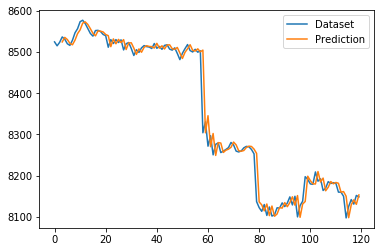

In [180]:
import matplotlib.pyplot as plt
import numpy as np

predict = model.predict(data_x)
predict_inv = scaler.inverse_transform(predict)
predict_plot = np.empty_like(dataset)
predict_plot[:, :] = np.nan
predict_plot[look_back:, :] = predict_inv

plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(predict_plot, label='Prediction')
plt.legend()
plt.show()